# Full energy optimization demo

This notebook shows how to build optimization inputs from the Newcastle Urban Case
study data (metadata, weather, and stochastic occupant-driven profiles) and then
plot the resulting consumption and comfort trajectories.

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure repository code is importable
import sys
from pathlib import Path

def find_repo_root(start=None):
    path = Path(start or Path.cwd()).resolve()
    for candidate in [path] + list(path.parents):
        if (candidate / '.git').exists():
            return candidate
    return path

repo_root = find_repo_root()
sys.path.append(str(repo_root / 'Codes' / 'sourcecode'))

from RC_Optimization import optimize_full_energy_system, build_tariff


## Build inputs

- Load dwelling metadata (R, C, g, occupants) from the updated Newcastle Urban Case CSV
- Load the winter weather time series (outdoor temperature and solar irradiance)
- Sample daily hot-water demand, appliance consumption, and EV availability profiles
  from the stochastic CREST-style CSVs based on occupant count
- Build time-aligned tariffs and set-point schedules for optimization


In [4]:
# Paths to prepared datasets (update if your repo layout differs)
data_root = repo_root / 'Input data'
meta_path = data_root / 'Newcastle_Urban_Case_meta_updated.csv'
weather_path = data_root / 'NEcase_20_21_t2m_ssrd_30min.csv'
profile_root = data_root / 'Stochastic_Demands'

# Profile column mapping (update after inspecting the stochastic demand files)
profile_column_map = {
    'hotwater': ['hotwater_L'],
    'appliance': ['appliance_demand_W'],
    'ev_availability': ['ev_available'],
}

# Analysis horizon
step = '30min'
steps_per_day = int(pd.Timedelta('1D') / pd.Timedelta(step))

# Load metadata
meta = pd.read_csv(meta_path)

# Inspect metadata columns
print('Metadata columns:', list(meta.columns))
display(meta.head())

# Explicit column names (updated to match the main-branch CSV headers)
meta_columns = {
    'occupants': 'No_occupants',
    'R1': 'R1',
    'C1': 'C1',
    'g': 'g',
}

weather_columns = {
    'time': 'timestamp',
    't2m': 't2m',
    'ssrd': 'ssrd',
}



def _load_daily_samples_from_array(data, steps_per_day):
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    if data.shape[0] == steps_per_day:
        return data, 1
    if data.shape[1] == steps_per_day:
        return data, 0

    flat = data.reshape(-1)
    if flat.size % steps_per_day == 0:
        reshaped = flat.reshape(-1, steps_per_day)
        return reshaped, 0

    raise ValueError(f'Cannot infer daily samples from array with shape {data.shape}')


def select_profile_by_index(samples, axis, idx, steps_per_day):
    if axis == 1:
        profile = samples[:, idx]
    else:
        profile = samples[idx, :]
    if len(profile) < steps_per_day:
        profile = np.pad(profile, (0, steps_per_day - len(profile)), mode='edge')
    elif len(profile) > steps_per_day:
        profile = profile[:steps_per_day]
    return profile


def find_occ_profile_file(root, occ):
    root = Path(root)
    csv_paths = sorted(root.glob('*.csv'))
    if not csv_paths:
        raise FileNotFoundError(f'No CSV files found in {root}')

    occ = int(occ)
    for path in csv_paths:
        name = path.stem.lower()
        if f'occ{occ}' in name or f'occ_{occ}' in name or f'occ-{occ}' in name:
            return path

    # Fallback: if there are 5 files, map occupant 1-5 to sorted order
    if len(csv_paths) == 5 and 1 <= occ <= 5:
        return csv_paths[occ - 1]

    raise FileNotFoundError(
        f'No occupant-specific profile CSV found for occ={occ} in {root}. '
        'Rename the files to include "occ{n}" or update the matching logic.'
    )


occ_col = meta_columns['occupants']
r_col = meta_columns['R1']
c_col = meta_columns['C1']
g_col = meta_columns['g']

# Load weather
weather = pd.read_csv(weather_path,comment='#')

# Inspect weather columns
print('Weather columns:', list(weather.columns))
display(weather.head())

time_col = weather_columns['time']
if time_col in weather.columns:
    weather[time_col] = pd.to_datetime(weather[time_col],format='%d/%m/%Y %H:%M')
    weather = weather.set_index(time_col)
else:
    weather.index = pd.date_range('2020-01-01', periods=len(weather), freq=step)

weather = weather.sort_index()

# Pick temperature and irradiance columns
temp_col = weather_columns['t2m']
solar_col = weather_columns['ssrd']
if temp_col not in weather.columns:
    raise KeyError(f'Column {temp_col} not found in weather CSV.')
if solar_col not in weather.columns:
    raise KeyError(f'Column {solar_col} not found in weather CSV.')

Tout = weather[temp_col].astype(float)
if Tout.median() > 100:
    Tout = Tout - 273.15

# Convert ssrd to W/m^2 if needed
S = weather[solar_col].astype(float)

dt_seconds = (weather.index[1] - weather.index[0]).total_seconds()
if S.max() > 2000:
    S = S / dt_seconds

# Select a shorter window for demo runs (change n_days or start_date as needed)
start_date = weather.index[0].normalize()
n_days = 2
end_date = start_date + pd.Timedelta(days=n_days)
window = weather.loc[start_date:end_date - pd.Timedelta(step)]
Tout = Tout.loc[window.index].to_numpy()
S = S.loc[window.index].to_numpy()

# Tariff aligned with weather window
Tariff_start = window.index[0]
tariff = build_tariff(Tariff_start, n_days=n_days, step=step, type='cosy')
if not tariff.index.equals(window.index):
    tariff = tariff.reindex(window.index, method='ffill')

n_steps = len(tariff)

# Heating set-points
hours = tariff.index.hour + tariff.index.minute / 60.0
comfort_setpoint = np.where((hours >= 6) & (hours < 9) | (hours >= 17) & (hours < 22), 21.0, 17.0)
flex_setpoint = np.where((hours >= 6) & (hours < 8) | (hours >= 18) & (hours < 21), 20.0, 16.0)
setpoint_sequences = [comfort_setpoint, flex_setpoint]

# Helpers to sample daily profiles
rng = np.random.default_rng(42)
profile_keywords = profile_column_map


def sample_stochastic_profiles(path, n_days, steps_per_day, rng):
    df = pd.read_csv(path)
    profile_data = {key: [] for key in profile_keywords}
    chosen_indices = []

    for _ in range(n_days):
        run_idx = int(rng.integers(1, 1001))
        chosen_indices.append(run_idx)
        resolved = []
        min_days = None
        for profile_key, profile_cols in profile_keywords.items():
            col = f"run_{run_idx}_{profile_cols[0]}"
            if col not in df.columns:
                raise KeyError(f"Expected column {col} in {path}.")
            series = pd.to_numeric(df[col], errors='coerce').fillna(0).to_numpy()
            samples, axis = _load_daily_samples_from_array(series, steps_per_day)
            resolved.append((profile_key, samples, axis))
            n_candidates = samples.shape[1] if axis == 1 else samples.shape[0]
            min_days = n_candidates if min_days is None else min(min_days, n_candidates)

        if min_days is None or min_days == 0:
            raise ValueError(f'No daily samples found in {path} for run {run_idx}.')

        day_idx = int(rng.integers(0, min_days))

        for profile_key, samples, axis in resolved:
            profile = select_profile_by_index(samples, axis, day_idx, steps_per_day)
            profile_data[profile_key].append(profile)

    for profile_type in profile_keywords:
        profile_data[profile_type] = np.concatenate(profile_data[profile_type])

    chosen_by_type = {profile_type: chosen_indices for profile_type in profile_keywords}

    return profile_data, chosen_by_type


# Build per-dwelling inputs based on occupant count

# Inspect a sample stochastic profile file to confirm column names
try:
    sample_profile_path = find_occ_profile_file(profile_root, 1)
    sample_profile = pd.read_csv(sample_profile_path)
    print(f'Stochastic profile sample file: {sample_profile_path.name}')
    print('Profile columns:', list(sample_profile.columns))
    display(sample_profile.head())
except FileNotFoundError as exc:
    print(exc)
max_dwellings = None  # set to an int for quicker runs in the demo

if max_dwellings:
    meta_iter = meta.head(max_dwellings).copy()
else:
    meta_iter = meta

dwelling_inputs = {}
for idx, row in meta_iter.iterrows():
    occ = row[occ_col]
    profile_path = find_occ_profile_file(profile_root, occ)
    profiles, chosen = sample_stochastic_profiles(profile_path, n_days, steps_per_day, rng)

    appliance_profile = profiles['appliance']

    # Appliance profile: assume kW if values are small, otherwise W
    if np.nanmax(appliance_profile) < 50:
        base_electric = appliance_profile * 1000
    else:
        base_electric = appliance_profile

    dwelling_inputs[idx] = {
        'occ': occ,
        'meta': row,
        'hw_demand': profiles['hotwater'],
        'base_electric': base_electric,
        'ev_availability': profiles['ev_availability'],
        'samples': chosen,
        'profile_path': str(profile_path),
    }

print(f'Prepared inputs for {len(dwelling_inputs)} dwellings over {n_days} days.')






Metadata columns: ['Property_ID', 'Delivery_Contractor', 'Postcode_1', 'Participant_Age', 'EmployStatus', 'EmployType', 'HouseIncome', 'Date_Contact', 'Tenure', 'Tenure_Length', 'Social_Group', 'HP_Awareness', 'Reason_Sustainability', 'Sustainability_exp', 'Reason_Future', 'Future_exp', 'Reason_Upgrade', 'Upgrade_exp', 'Reason_Building', 'Building_exp', 'Reason_Financial', 'Financial_exp', 'Reason_Technology', 'Technology_exp', 'Reason_Research', 'Research_exp', 'Reason_Planned', 'Planned_exp', 'Reason_Replacement', 'Replacement_exp', 'Reason_Other', 'Other_exp', 'Date_Survey', 'Name_Survey', 'House_Type', 'House_Form', 'House_Env', 'House_Age', 'House_SAP', 'No_Adults', 'No_Child', 'No_Storeys', 'Total_Floor_Area', 'Habitable_Rooms', 'Bedrooms', 'Heated_rooms', 'Floor_Height', 'Wall_Type', 'Floor_Type', 'Roof_Type', 'Glazed_Type', 'Mains_Gas_Flag', 'Main_Fuel', 'Heat_Primary_Source', 'Heat_Secondary_Source', 'TS_Existing', 'TS_Existing_Size', 'No_Underfloor', 'Existing_Fires', 'Existi

,Property_ID,Delivery_Contractor,Postcode_1,Participant_Age,EmployStatus,EmployType,HouseIncome,Date_Contact,Tenure,Tenure_Length,...,test_days,rmse_train,rmse_val,rmse_average,train_day_count,test_day_count,R1,C1,g,No_occupants
0,EOH2728,E.ON,NE10,43.0,Working Full time (>30hrs),Manager,"40,001 - 50,000",2021-01-22T00:00:00.000Z,Owner-Occupied,4.0,...,"2022-01-04,2022-01-23,2022-02-21,2022-02-25,20...",0.211586,0.257162,0.234374,10,5,0.006437,1.527676e+08,1.342996,1
1,EOH0810,E.ON,NE11,69.0,Retired,Pensioner,"50,001+",2021-02-22T00:00:00.000Z,Owner-Occupied,4.0,...,"2021-12-03,2021-12-09,2022-01-04,2022-02-01,20...",0.256923,0.435521,0.346222,10,5,0.003909,4.144274e+07,11.386321,2
2,EOH2128,E.ON,NE12,NaN,Working Full time (>30hrs),Professional,"40,001 - 50,000",2020-12-11T00:00:00.000Z,Owner-Occupied,0.9,...,"2021-12-25,2022-01-11,2022-01-14,2022-02-24,20...",0.762168,0.975196,0.868682,10,5,0.006679,2.115581e+07,3.886073,2
3,EOH1578,E.ON,NE12,NaN,Working Full time (>30hrs),Skilled Manual Worker,"25,001 - 30,000",2021-07-27T00:00:00.000Z,Owner-Occupied,16.0,...,"2021-12-01,2021-12-18,2022-02-15,2022-02-17,20...",0.541554,0.556596,0.549075,10,5,0.006532,2.172207e+07,2.967896,2
4,EOH3082,E.ON,NE12,58.0,Working Full time (>30hrs),Clerical,"40,001 - 50,000",2021-03-04T00:00:00.000Z,Owner-Occupied,15.0,...,"2021-12-18,2022-01-09,2022-01-13,2022-01-19,20...",0.400614,0.779339,0.589976,10,5,0.006285,3.769104e+07,0.000001,3


Weather columns: ['timestamp', 't2m', 'ssrd']


,timestamp,t2m,ssrd
0,01/12/2020 00:00,5.60,0
1,01/12/2020 00:30,5.45,0
2,01/12/2020 01:00,5.30,0
3,01/12/2020 01:30,5.25,0
4,01/12/2020 02:00,5.20,0


Stochastic profile sample file: crest_wd_occ1_30min.csv
Profile columns: ['time', 'run_0_hotwater_L', 'run_0_occupancy', 'run_0_activity', 'run_0_appliance_demand_W', 'run_1_hotwater_L', 'run_1_occupancy', 'run_1_activity', 'run_1_appliance_demand_W', 'run_2_hotwater_L', 'run_2_occupancy', 'run_2_activity', 'run_2_appliance_demand_W', 'run_3_hotwater_L', 'run_3_occupancy', 'run_3_activity', 'run_3_appliance_demand_W', 'run_4_hotwater_L', 'run_4_occupancy', 'run_4_activity', 'run_4_appliance_demand_W', 'run_5_hotwater_L', 'run_5_occupancy', 'run_5_activity', 'run_5_appliance_demand_W', 'run_6_hotwater_L', 'run_6_occupancy', 'run_6_activity', 'run_6_appliance_demand_W', 'run_7_hotwater_L', 'run_7_occupancy', 'run_7_activity', 'run_7_appliance_demand_W', 'run_8_hotwater_L', 'run_8_occupancy', 'run_8_activity', 'run_8_appliance_demand_W', 'run_9_hotwater_L', 'run_9_occupancy', 'run_9_activity', 'run_9_appliance_demand_W', 'run_10_hotwater_L', 'run_10_occupancy', 'run_10_activity', 'run_10_

,time,run_0_hotwater_L,run_0_occupancy,run_0_activity,run_0_appliance_demand_W,run_1_hotwater_L,run_1_occupancy,run_1_activity,run_1_appliance_demand_W,run_2_hotwater_L,...,run_990_ev_available,run_991_ev_available,run_992_ev_available,run_993_ev_available,run_994_ev_available,run_995_ev_available,run_996_ev_available,run_997_ev_available,run_998_ev_available,run_999_ev_available
0,2026-01-15 00:00:00,0.0,0,0,62.000000,0.0,1,0,96.833333,0.0,...,1,1,1,1,1,1,1,1,1,1
1,2026-01-15 00:30:00,0.0,0,0,62.000000,0.0,1,0,170.833333,0.0,...,1,1,1,1,1,1,1,1,1,1
2,2026-01-15 01:00:00,0.0,0,0,62.000000,0.0,1,0,66.000000,0.0,...,1,1,1,1,1,1,1,1,1,1
3,2026-01-15 01:30:00,0.0,0,0,198.400000,0.0,1,0,170.833333,0.0,...,1,1,1,1,1,1,1,1,1,1
4,2026-01-15 02:00:00,0.0,0,0,151.133333,0.0,1,0,96.833333,0.0,...,1,1,1,1,1,1,1,1,1,1


Prepared inputs for 147 dwellings over 2 days.


In [6]:
for i,(d_id, d_input) in enumerate(dwelling_inputs.items()):
    print(f"Dwelling {i+1}: ID={d_id}, Occupants={d_input['occ']}, Profile file={d_input['profile_path']}, Sampled runs={d_input['samples']}")
    if i >= 2:
        print("...")  # Limit output for brevity
        break

Dwelling 1: ID=0, Occupants=1, Profile file=E:\GitHubProjects\LV network\Input data\Stochastic_Demands\crest_wd_occ1_30min.csv, Sampled runs={'hotwater': [90, 774], 'appliance': [90, 774], 'ev_availability': [90, 774]}
Dwelling 2: ID=1, Occupants=2, Profile file=E:\GitHubProjects\LV network\Input data\Stochastic_Demands\crest_wd_occ2_30min.csv, Sampled runs={'hotwater': [655, 439], 'appliance': [655, 439], 'ev_availability': [655, 439]}
Dwelling 3: ID=2, Occupants=2, Profile file=E:\GitHubProjects\LV network\Input data\Stochastic_Demands\crest_wd_occ2_30min.csv, Sampled runs={'hotwater': [434, 859], 'appliance': [434, 859], 'ev_availability': [434, 859]}
...


## Run the optimization

We evaluate both set-point schedules in one call. The solver returns the optimal solution for each schedule and highlights the least-cost option via the `best_key` and `best_result` entries.

Hot-water handling can be configured with `hw_mode`:
- `boiler_only` for HHP dwellings without storage (all DHW from the boiler).
- `hp_storage` for mHP dwellings with a storage tank following the additional constraints.
- `hybrid_direct` to retain the previous direct split between heat pump and boiler.

The storage case now tracks the stored **volume** at a fixed 55°C tank temperature per the provided formulation.


In [9]:
# Select a dwelling to optimize
selected_dwelling_id = next(iter(dwelling_inputs))
selected = dwelling_inputs[selected_dwelling_id]

print(selected_dwelling_id)
print(selected)

0
{'occ': 1, 'meta': Property_ID                               EOH2728
Delivery_Contractor                          E.ON
Postcode_1                                   NE10
Participant_Age                              43.0
EmployStatus           Working Full time (>30hrs)
                                  ...            
test_day_count                                  5
R1                                       0.006437
C1                               152767638.161129
g                                        1.342996
No_occupants                                    1
Name: 0, Length: 145, dtype: object, 'hw_demand': array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  3.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
       55.56, 35.44,  0.  ,  4.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
       79.  ,  0.  ,  2.  ,  2.  ,  0.  ,  0.  ,  2.  ,  0.  ,  0.  ,
        2.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  5.  ,
        0.  ,  0.  ,  0.  ,  

In [34]:

# Thermal model parameters from metadata
params = {
    'R1': float(selected['meta'][r_col]) if r_col else 1 / 200,
    'C1': float(selected['meta'][c_col]) if c_col else 3e7,
    'g': float(selected['meta'][g_col]) if g_col else 10.0,
    'dt': dt_seconds,
    'T0': 19,
    'tol': 1.0,
    'COP': 3.5,
    'etaB': 0.9,
    'Qhp_max': 9.5e3,   # W
    'Qbo_max': 0e3,  # W
}

hw_demand = selected['hw_demand']
# CREST hotwater profiles are in liters per 30 min; convert to m^3 per step.
hw_demand_m3 = hw_demand / 1000.0
base_electric = selected['base_electric']

# EV parameters (availability from profile; assume full battery at start)
ev_capacity_kwh = 80.0

ev_params = {
    'ev_capacity': ev_capacity_kwh,  # kWh
    'ev_target': 0.5 * ev_capacity_kwh,
    'ev_charge_max': 11.0,  # kW
    'ev_availability': selected['ev_availability'],
    'eta_ev_charge': 0.95,
    'ev_travel_energy': np.zeros(n_steps),
}

# Hot water configuration: switch to 'boiler_only' for HHP without storage,
# or keep 'hp_storage' to mimic the mHP case with a cylinder.
hw_params = {
    'hw_mode': 'hp_storage',  #{"hybrid_direct", "boiler_only", "hp_storage"}
    'V_stor': 0.2,       # m^3 storage volume capacity
    'V_stor_init': 0.12, # initial stored volume (m^3)
    'T_mains': 10.0,
    'T_hw_supply': 40.0,
}

results = optimize_full_energy_system(
    tariff=tariff,
    Tout=Tout,
    S=S,
    setpoint_sequences=setpoint_sequences,
    hw_demand=hw_demand_m3,
    base_electric=base_electric,
    day_ahead=True,
    **params,
    **ev_params,
    **hw_params,
)

best_key = results.get('best_key', next(k for k in results if k.startswith('schedule_')))
best = results['best_result']['results'] if 'best_result' in results else results[best_key]['results']
best_cost = results['best_result']['cost'] if 'best_result' in results else results[best_key]['cost']
print(f"Best schedule: {best_key}, total cost = {best_cost:.2f}")

best.head()



Best schedule: schedule_1, total cost = 328945.86


,Tin,T_set,T_low,T_high,Q_hp_space,Q_bo_space,Q_hp_hw,Q_bo_hw,T_stor,V_stor,elec_cost,gas_cost,P_ev_charge,ev_soc
2020-12-01 00:00:00,19.00000,16.00000,15.00000,NaN,0.00000,0.00000,0.00000,0.00000,55.00000,0.12000,602.00000,0.00000,0.00000,80.00000
2020-12-01 00:30:00,18.97547,16.00000,15.00000,NaN,0.00000,0.00000,0.00000,0.00000,55.00000,0.12000,1109.50000,0.00000,0.00000,80.00000
2020-12-01 01:00:00,18.95071,16.00000,15.00000,NaN,0.00000,0.00000,0.00000,0.00000,55.00000,0.12000,457.50000,0.00000,0.00000,80.00000
2020-12-01 01:30:00,18.92573,16.00000,15.00000,NaN,0.00000,0.00000,0.00000,0.00000,55.00000,0.12000,1270.00000,0.00000,0.00000,80.00000
2020-12-01 02:00:00,18.90069,16.00000,15.00000,NaN,0.00000,0.00000,0.00000,0.00000,55.00000,0.12000,435.00000,0.00000,0.00000,80.00000


## Plot consumption profiles

The figure shows:

- Electricity and gas prices
- Indoor temperature versus comfort band
- Space and hot water heat delivery
- Storage tank water temperature when `hw_mode='hp_storage'`
- EV state of charge
- Aggregate electricity and gas consumption profiles


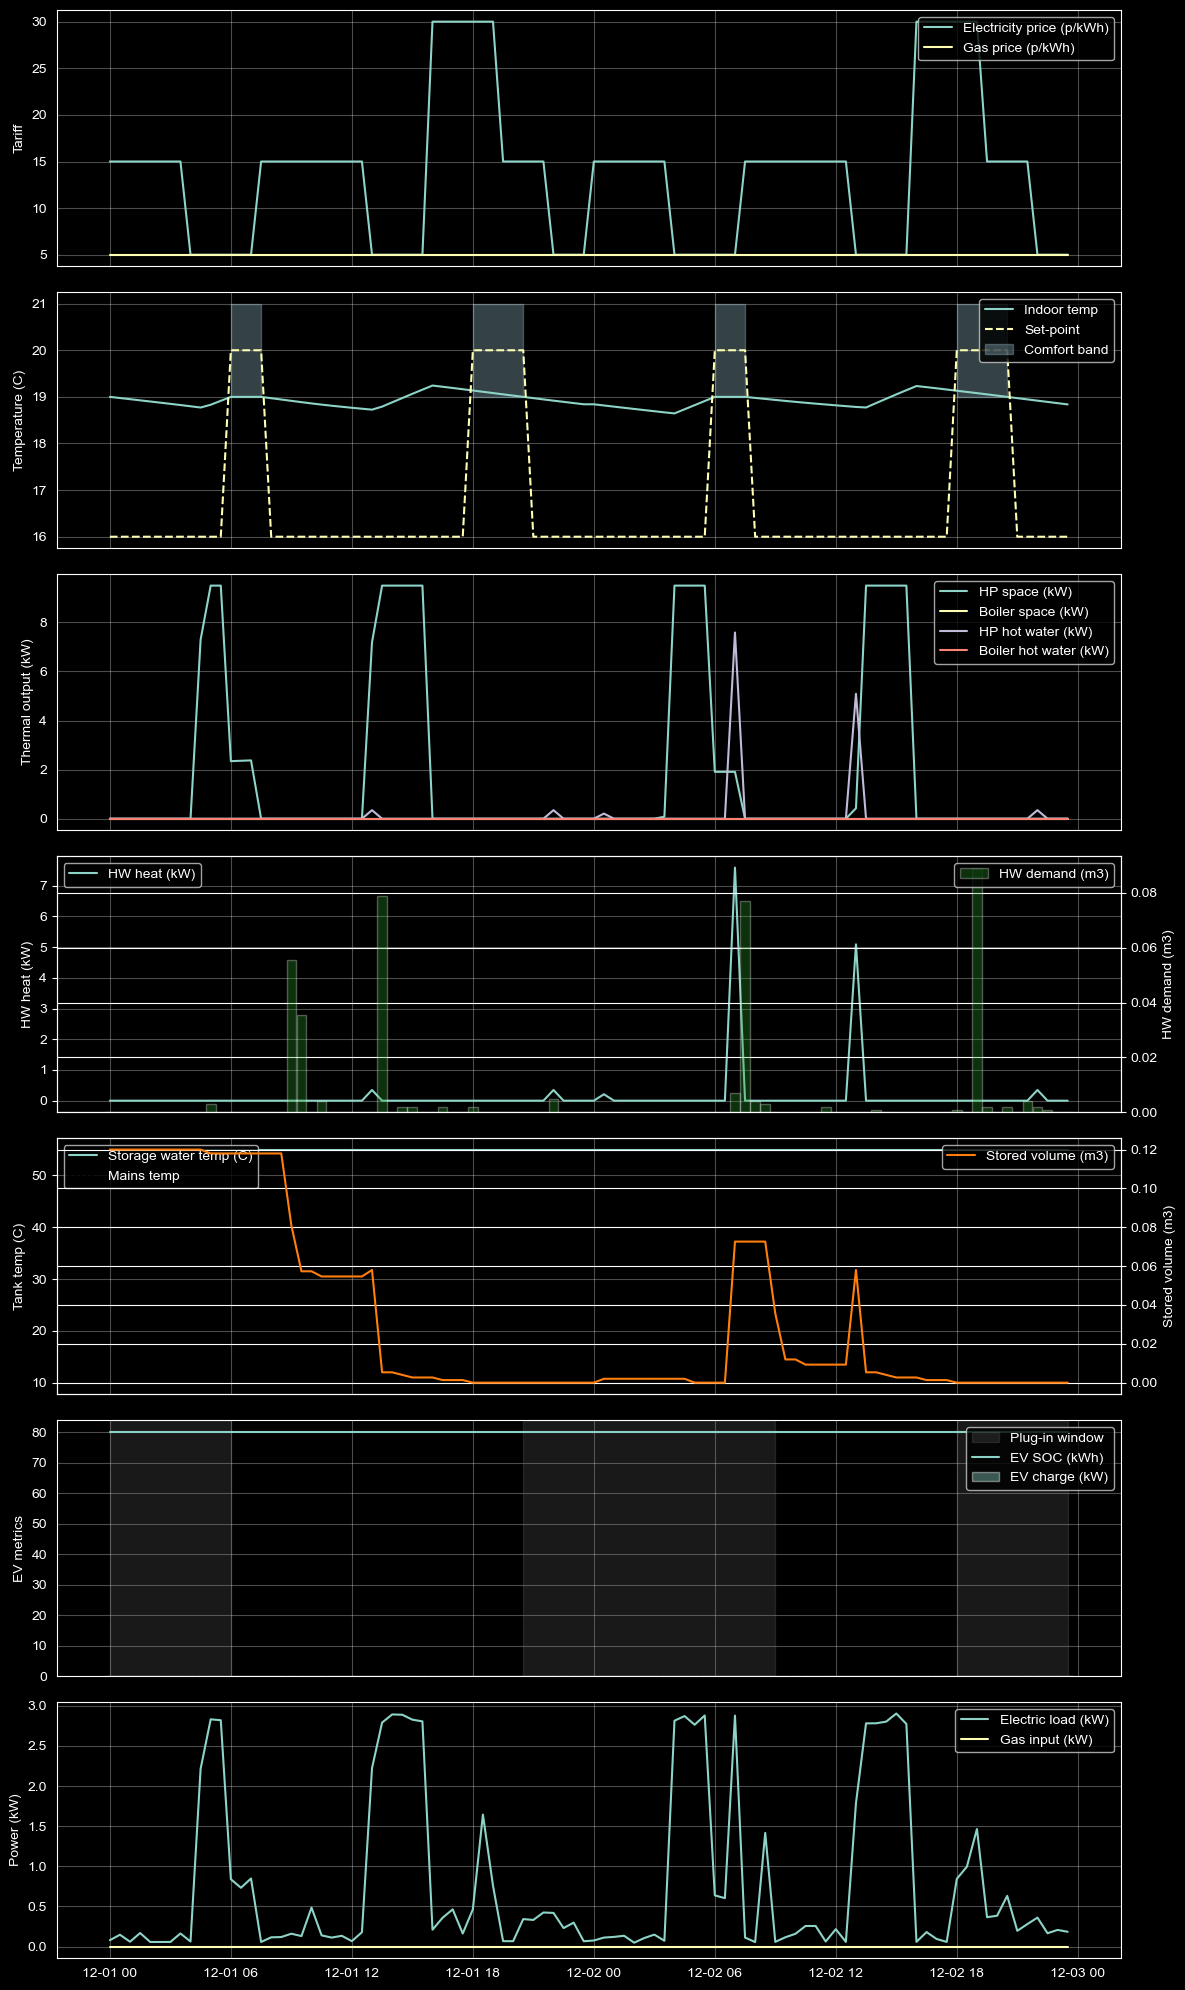

In [35]:
use_storage = np.isfinite(best['T_stor']).any()

n_rows = 7 if use_storage else 6
fig, axs = plt.subplots(n_rows, 1, figsize=(12, 20 if use_storage else 18), sharex=True)

# Tariff
axs[0].plot(tariff.index, tariff['elec_price'], label='Electricity price (p/kWh)')
axs[0].plot(tariff.index, tariff['gas_price'], label='Gas price (p/kWh)')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Tariff')
axs[0].grid(True, alpha=0.3)

# Indoor temperature
axs[1].plot(best.index, best['Tin'], label='Indoor temp')
axs[1].plot(best.index, best['T_set'], '--', label='Set-point')
axs[1].fill_between(best.index, best['T_low'], best['T_high'], color='lightblue', alpha=0.3, label='Comfort band')
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Temperature (C)')
axs[1].grid(True, alpha=0.3)

# Space and DHW thermal output
axs[2].plot(best.index, best['Q_hp_space'] / 1000, label='HP space (kW)')
axs[2].plot(best.index, best['Q_bo_space'] / 1000, label='Boiler space (kW)')
axs[2].plot(best.index, best['Q_hp_hw'] / 1000, label='HP hot water (kW)')
axs[2].plot(best.index, best['Q_bo_hw'] / 1000, label='Boiler hot water (kW)')
axs[2].legend(loc='upper right')
axs[2].set_ylabel('Thermal output (kW)')
axs[2].grid(True, alpha=0.3)

# Hot water: heat vs demand (separate axis)
hw_ax = axs[3]
hw_ax.plot(best.index, (best['Q_hp_hw'] + best['Q_bo_hw']) / 1000, label='HW heat (kW)')
hw_ax.set_ylabel('HW heat (kW)')
hw_ax.grid(True, alpha=0.3)
hw_ax.legend(loc='upper left')

demand_ax = hw_ax.twinx()
demand_ax.bar(best.index, hw_demand_m3, width=0.02, alpha=0.3, color='tab:green', label='HW demand (m3)')
demand_ax.set_ylabel('HW demand (m3)')
demand_ax.legend(loc='upper right')

# Storage panel (optional)
if use_storage:
    tank_ax = axs[4]
    vol_ax = tank_ax.twinx()
    tank_ax.plot(best.index, best['T_stor'], label='Storage water temp (C)')
    tank_ax.axhline(hw_params.get('T_mains', np.nan), color='k', linestyle=':', label='Mains temp')
    vol_ax.plot(best.index, best['V_stor'], color='tab:orange', label='Stored volume (m3)')
    tank_ax.legend(loc='upper left')
    vol_ax.legend(loc='upper right')
    tank_ax.set_ylabel('Tank temp (C)')
    vol_ax.set_ylabel('Stored volume (m3)')
    tank_ax.grid(True, alpha=0.3)

# EV
if use_storage:
    ev_ax = axs[5]
else:
    ev_ax = axs[4]

plugin_series = pd.Series(ev_params['ev_availability'], index=best.index)
plugged = plugin_series > 0.5
if plugged.any():
    spans = []
    start = None
    for ts, avail in plugged.items():
        if avail and start is None:
            start = ts
        elif not avail and start is not None:
            spans.append((start, ts))
            start = None
    if start is not None:
        spans.append((start, plugin_series.index[-1]))
    for i, (s, e) in enumerate(spans):
        ev_ax.axvspan(s, e, color='gray', alpha=0.2, label='Plug-in window' if i == 0 else None)

ev_ax.plot(best.index, best['ev_soc'], label='EV SOC (kWh)')
ev_ax.bar(best.index, best['P_ev_charge'], width=0.02, alpha=0.4, label='EV charge (kW)')
ev_ax.legend(loc='upper right')
ev_ax.set_ylabel('EV metrics')
ev_ax.grid(True, alpha=0.3)

# Aggregate consumption
heat_pump_elec = (best['Q_hp_space'] + best['Q_hp_hw']) / params['COP'] / 1000
other_elec = base_electric / 1000
ev_elec = best['P_ev_charge']
gas_input = (best['Q_bo_space'] + best['Q_bo_hw']) / params['etaB'] / 1000

agg_ax = axs[6] if use_storage else axs[5]
agg_ax.plot(best.index, heat_pump_elec + other_elec + ev_elec, label='Electric load (kW)')
agg_ax.plot(best.index, gas_input, label='Gas input (kW)')
agg_ax.legend(loc='upper right')
agg_ax.set_ylabel('Power (kW)')
agg_ax.grid(True, alpha=0.3)

plt.xlabel('Time')
plt.tight_layout()
plt.show()